In [1]:
from myutils import GetImageAnnotationPairs,GetPredBboxes,GetImageBox
import torch
import matplotlib.pyplot as plt
%matplotlib inline
#use standard sizes for all figures
SMALL_SIZE = 10
MEDIUM_SIZE = 25
BIGGER_SIZE = 30


plt.rc('font', size = BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize = MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize = BIGGER_SIZE)   # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
import math

In [ ]:
exp_list = {'control':1,'lights_off':1,'lights_low':1,'lights_high':1,'two_droplet':2,
            'three_droplet':3,'res_mid':1,'res_low':1,'faraday':1,'corral_white':1,
           '2white2black_10m':4,'3white':3,'2white2black_20m':4}

## Training Results Plot

In [ ]:
def PlotmAP(exp_name,save_dir='./figures/'):
    df = pd.read_csv(f'train_results/{exp_name}.csv',skipinitialspace = True)
    epochs = df['epoch']
    mAP_05 = df['metrics/mAP_0.5']
    mAP_0595 = df['metrics/mAP_0.5:0.95']
    #plot
    fig,ax = plt.subplots(figsize=(8,6))
    ax.plot(epochs, mAP_05, label='mAP@0.5', linestyle='--')
    ax.plot(epochs, mAP_0595, label='mAP@0.5:0.95')
    ax.set_xlabel('epochs')
    ax.set_ylabel('score')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    ax.set_rasterized(True)
    plt.savefig(f'{save_dir}/{exp_name}.eps',bbox_inches = 'tight',pad_inches = 0,format='eps', dpi=150)
    #plt.show()


In [ ]:
# PlotmAP(exp_name='combined_droplet')
# PlotmAP(exp_name='combined_intruder')

In [ ]:
df = pd.read_csv('train_results/combined_droplet.csv',skipinitialspace = True)
epochs = df['epoch']
mAP_05 = df['metrics/mAP_0.5']
mAP_0595 = df['metrics/mAP_0.5:0.95']
#plot
fig,ax = plt.subplots(1,2,figsize=(18,8),sharey=True)

ax[0].plot(epochs, mAP_05, label='mAP@0.5', linestyle='--')
ax[0].plot(epochs, mAP_0595, label='mAP@0.5:0.95')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('score')
ax[0].grid(True)
ax[0].legend()
ax[0].set_rasterized(True)

df = pd.read_csv('train_results/combined_intruder.csv',skipinitialspace = True)
epochs = df['epoch']
mAP_05 = df['metrics/mAP_0.5']
mAP_0595 = df['metrics/mAP_0.5:0.95']

ax[1].plot(epochs, mAP_05, label='mAP@0.5', linestyle='--')
ax[1].plot(epochs, mAP_0595, label='mAP@0.5:0.95')
ax[1].set_xlabel('epochs')
#ax[0].set_ylabel('score')
ax[1].grid(True)
ax[1].legend()
ax[1].set_rasterized(True)



plt.tight_layout()
plt.savefig('figures/combine_scores.eps',bbox_inches = 'tight',format='eps', dpi=150)
#plt.show()


## Detection Samples Plots

In [ ]:
model_drop = "best_droplet.pt"
model_int = "best_intruder.pt"

In [ ]:
# import torch
# model = torch.hub.load('ultralytics/yolov5', 'custom',path = model_drop, force_reload = True)
model = torch.hub.load('ultralytics/yolov5', 'custom',path = model_int, force_reload = True)

In [ ]:
def PlotDetectionSamples(exp_name,num):
    """
    exp_name: experiments above
    num: random sample from test set. Make sure not to exceed
    the number of test images.
    """
    test_dir = f'datasets/annotations/{exp_name}/annot_images/test/'
    img_paths,label_paths = GetImageAnnotationPairs(test_dir)
    img_path = img_paths[num]
    
    label_path = label_paths[num]
    #make sure to get the right couple
    print(f"{img_path}\n{label_path}")
    #plot detection
    img2 = GetPredBboxes(model,img_path)
    plt.figure(figsize=(20,10))
    plt.tight_layout()
    plt.imshow(img2)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(f'figures/{exp_name}{num}.eps',bbox_inches = 'tight',pad_inches = 0,format='eps', dpi=150)
    plt.show()


In [ ]:
PlotDetectionSamples("3white",num=2)

## Plot Speed and Flow

In [ ]:
def GetDynamics(exp_name):
    if exp_name not in exp_list.keys():
        print(f'Enter a valid experiment name from the following list {exp_list.keys()}')
    else:
        df = pd.read_csv(f'tracking_results/{exp_name}.csv')
    
    nd = exp_list[exp_name]
    xlist = [f"x{i}" for i in range(1,nd+1)]
    dxlist = [f"dx{i}" for i in range(1,nd+1)]

    ylist = [f"y{i}" for i in range(1,nd+1)]
    dylist = [f"dy{i}" for i in range(1,nd+1)]

    slist = [f"speed{i}" for i in range(1,nd+1)]

    #get stuff column-wise
    t = df["time"].to_numpy()
    xc = df[xlist].to_numpy()
    dx = df[dxlist].to_numpy()

    yc = df[ylist].to_numpy()
    dy = df[dylist].to_numpy()

    speed = df[slist].to_numpy()
    
    return t, xc, yc, dx, dy, speed

In [ ]:
def PlotFlow(exp_name,save_dir='./figures/',sample_interval=5):
    # flow plot for single droplet experiments
    t, xc, yc, _, _, _ = GetDynamics(exp_name)
    plt.figure(figsize=(10, 8))
    x = xc[:,0][0:-1:sample_interval]
    y = yc[:,0][0:-1:sample_interval]
    dx = np.diff(x)
    dy = np.diff(y)
    dx1 = np.append(dx, 0)
    dy1 = -np.append(dy, 0)
    plt.plot(xc, yc, linestyle='-', color='tomato')
    #plt.quiver(x, y, dx1, dy1, color='blue', units='width')
    plt.plot(xc[0], yc[0], 'ks', label='initial point', markersize=15)
    plt.plot(xc[-1], yc[-1], 'ko', label='terminal point', markersize=15)
    plt.gca().invert_yaxis()
    plt.legend(loc='upper left',labelspacing = 1.5)
    plt.tight_layout()
    plt.savefig(f'{save_dir}/{exp_name}_path.eps',format='eps', dpi=120)
    plt.show()


def PlotSpeed(exp_name,save_dir='./figures/',s=40):
    # speed map
    sns.set(style='ticks', font_scale=1.5)
    _, xc, yc, _, _, speed = GetDynamics(exp_name)
    nd = xc.shape[1]
    for i in range(nd):
        fig,ax = plt.subplots(figsize=(8,6))
        ax.plot(xc[0,i], yc[0,i], 'ks', label='initial point', markersize=15)
        ax.plot(xc[-1,i], yc[-1,i], 'ko', label='terminal point', markersize=15)
        ax = sns.scatterplot(x=xc[:,i], y=yc[:,i], hue=speed[:,i], palette='coolwarm', s = 80)
        ax.set(xlabel=None, ylabel=None)
        norm = plt.Normalize(speed.min(), speed.max())
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        sm.set_array([])
        ax.invert_yaxis()
        # Remove the legend and add a colorbar
        ax.get_legend().remove()
        ax.figure.colorbar(sm, label='speed[px/sec]')
        ax.grid(False)
        plt.tight_layout()
        ax.set_rasterized(True)
        plt.savefig(f'{save_dir}/{exp_name}_speed{i}.eps',format='eps', dpi=100)
        #plt.savefig(f'{save_dir}/{exp_name}_speed{i}.jpg')
        plt.show()

In [ ]:
#PlotSpeed("control")
# PlotSpeed("lights_off")
# PlotSpeed("lights_high")
# PlotSpeed("res_mid")
#PlotSpeed("faraday")

In [ ]:
#PlotFlow("control")
#PlotFlow("lights_off")
#PlotFlow("lights_high")
#PlotFlow("res_mid")
#PlotFlow("faraday")

## StrongSort Experiments

**three_droplet experiment with tracks**

- This section is little bit messy, party because the process is nasty. I will include more info soon

In [2]:
path_image = 'comparison/three_droplet/annot_three_drop/images/'
path_label = 'comparison/three_droplet/annot_three_drop/labels/'
image_name_sorted = sorted(os.listdir(path_image), key=lambda x: int(os.path.splitext(x)[0]))
img_paths = [os.path.join(path_image,name) for name in image_name_sorted]
label_name_sorted = sorted(os.listdir(path_label), key=lambda x: int(os.path.splitext(x)[0]))
lab_paths = [os.path.join(path_label,name) for name in label_name_sorted]
n = len(img_paths)

In [3]:
nd = 3
drop = np.zeros((nd,n,2))
for i in range(n):
    img = cv2.imread(img_paths[i])
    H,W,_ = img.shape
    #read annotation files in "txt" format
    annot_df = pd.read_csv(lab_paths[i],sep=' ', header = None)
    for j in range(nd):
        #class_id,x0,y0,w0,h0
        x0,y0,w0,h0 = annot_df.iloc[j].to_list()[1:]
        
        #class_id = annot_array[0] 
        xmax = (x0 + w0/2) * W
        xmin = (x0 - w0/2) * W
        xc = (xmin + xmax)/2
        ymin = (y0 + h0/2) * H
        ymax = (y0 - h0/2) * H
        yc = (ymin + ymax)/2
        drop[j,i] = [xc,yc]
        
        
df_groundtruth = pd.DataFrame(columns=['frame_id','G_x1','G_y1','G_x2','G_y2','G_x3','G_y3'])
df_groundtruth['frame_id'] = np.arange(n,dtype=np.int32)
df_groundtruth[['G_x1','G_y1']] = drop[0]
df_groundtruth[['G_x2','G_y2']]= drop[1]
df_groundtruth[['G_x3','G_y3']] = drop[2]

In [4]:
df_groundtruth.head(3)

,frame_id,G_x1,G_y1,G_x2,G_y2,G_x3,G_y3
0,0,220.49994,175.000014,257.50016,206.999982,316.00002,194.000184
1,1,220.49994,175.999824,257.50016,208.000170,315.49994,194.499900
2,2,221.00002,177.000012,257.50016,207.500076,314.99986,192.999996


In [5]:
#process DeepSort tracks given in MOT format
def GetTracks(track_path_txt):
    #clean deep-sort tracking to the following format
    #(0=frame_id,1=ID,2=xmin,3=ymin,4=w,5=h)
    df = pd.read_csv(track_path_txt,sep=" ",header=None)
    df = df[[0,1,2,3,4,5]]
    cols = ['frame_id','ID','xmin','ymin','w','h']
    df.columns = cols
    df['xc'] = (df['xmin'] + 0.5*df['w'])
    df['yc'] = (df['ymin'] + 0.5*df['h'])
    
    return df

df_deepsort = GetTracks('comparison/three_droplet/three_droplets_sort_last.txt') 

print(df_deepsort.head(2))

#convert to the same format to df_groundtruth above
df_sort = pd.DataFrame(columns=['frame_id','D_x1','D_y1','D_x2','D_y2','D_x3','D_y3'])
frameid_list = df_deepsort['frame_id'].unique()
counter = 0
for idx in frameid_list:
    df_temp = df_deepsort[df_deepsort['frame_id']==idx]
    if df_temp.shape[0]==nd:
        IDs = df_temp['ID'].to_numpy()
        centers = df_temp[['xc','yc']].to_numpy()
        temp = centers.flatten()
        temp = np.insert(temp,0,int(idx))
        df_sort.loc[counter] = temp
        counter+=1

print("\nfinal form\n")
print(df_sort.head(2))

   frame_id  ID  xmin  ymin  w  h     xc     yc
0         3   0   253   204  9  8  257.5  208.0
1         3   1   217   171  8  9  221.0  175.5

final form

   frame_id   D_x1   D_y1   D_x2   D_y2   D_x3   D_y3
0       3.0  257.5  208.0  221.0  175.5  316.0  193.0
1       4.0  258.0  208.0  220.0  176.5  315.0  192.0


In [6]:
#these tracks are from our algorithm
df_mytrack = pd.read_csv('comparison/three_droplet/mytrack_three_droplet.csv')
df_mytrack[['frame_id','x1','y1', 'x2' ,'y2' ,'x3', 'y3']]
df_mytrack.head(2)

,frame_id,time,x1,y1,x2,y2,x3,y3,c1,c2,c3,dx1,dy1,speed1,dx2,dy2,speed2,dx3,dy3,speed3
0,1.0,0.00,257.151611,206.454422,315.414246,193.812927,220.321655,174.390778,0.856632,0.849209,0.844197,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,0.04,257.136139,207.514832,315.335327,193.178192,220.519592,175.295807,0.855651,0.853946,0.834340,-0.38681,26.510239,26.51306,-1.972961,-15.868378,15.990559,4.948425,22.625732,23.160541


In [7]:
df_groundtruth.head(2)

,frame_id,G_x1,G_y1,G_x2,G_y2,G_x3,G_y3
0,0,220.49994,175.000014,257.50016,206.999982,316.00002,194.000184
1,1,220.49994,175.999824,257.50016,208.000170,315.49994,194.499900


In [8]:
#here we combine all the tracks into a single dataframe
frameid_real = set(df_groundtruth['frame_id'])
frameid_pred = set(df_mytrack['frame_id'])
frameid_sort = set(df_sort['frame_id'])
frame_id_final = list(frameid_sort.intersection(frameid_pred).intersection(frameid_real))

cols = ['frame_id',
        'G_x1','G_y1','G_x2','G_y2','G_x3','G_y3',
       'H_x1','H_y1','H_x2','H_y2','H_x3','H_y3',
       'D_x1','D_y1','D_x2','D_y2','D_x3','D_y3']
df = pd.DataFrame(columns=cols)

#this piece must be entered by hand, due to the randomness of the order of tracks. 
#I can automize this but it is not really necessary

for i,idx in enumerate(frame_id_final):
    temp = df_groundtruth[df_groundtruth['frame_id']==idx][['G_x1','G_y1','G_x2','G_y2','G_x3','G_y3']].values.flatten()
    temp = np.append(temp,df_mytrack[df_mytrack['frame_id']==idx][['x3','y3', 'x1' ,'y1' ,'x2', 'y2']].values.flatten())
    temp = np.append(temp,df_sort[df_sort['frame_id']==idx][['D_x2','D_y2','D_x1','D_y1','D_x3','D_y3']].values.flatten()) 
    temp = np.insert(temp,0,idx)
    df.loc[i] = temp
    
df = df.astype(int)
#write just in case
df.to_csv('comparison/three_droplet/three_droplet_combined_tracks.csv')
#this is the final clean track for each of the droplets
df.head(2)

,frame_id,G_x1,G_y1,G_x2,G_y2,G_x3,G_y3,H_x1,H_y1,H_x2,H_y2,H_x3,H_y3,D_x1,D_y1,D_x2,D_y2,D_x3,D_y3
0,3,220,177,257,209,316,192,220,176,257,207,315,192,221,175,257,208,316,193
1,4,220,179,257,210,316,192,220,177,257,209,315,191,220,176,258,208,315,192


In [9]:
drop1_real = df[['G_x1','G_y1']].values
drop1_pred = df[['H_x1','H_y1']].values
drop1_sort = df[['D_x1' ,'D_y1']].values
xg1 = drop1_real[:,0]
yg1 = drop1_real[:,1]
xh1 = drop1_pred[:,0]
yh1 = drop1_pred[:,1]
xd1 = drop1_sort[:,0]
yd1 = drop1_sort[:,1]

drop2_real = df[['G_x2','G_y2']].values
drop2_pred = df[['H_x2','H_y2']].values
drop2_sort = df[['D_x2' ,'D_y2']].values
xg2 = drop2_real[:,0]
yg2 = drop2_real[:,1]
xh2 = drop2_pred[:,0]
yh2 = drop2_pred[:,1]
xd2 = drop2_sort[:,0]
yd2 = drop2_sort[:,1]

drop3_real = df[['G_x3','G_y3']].values
drop3_pred = df[['H_x3','H_y3']].values
drop3_sort = df[['D_x3' ,'D_y3']].values
xg3 = drop3_real[:,0]
yg3 = drop3_real[:,1]
xh3 = drop3_pred[:,0]
yh3 = drop3_pred[:,1]
xd3 = drop3_sort[:,0]
yd3 = drop3_sort[:,1]

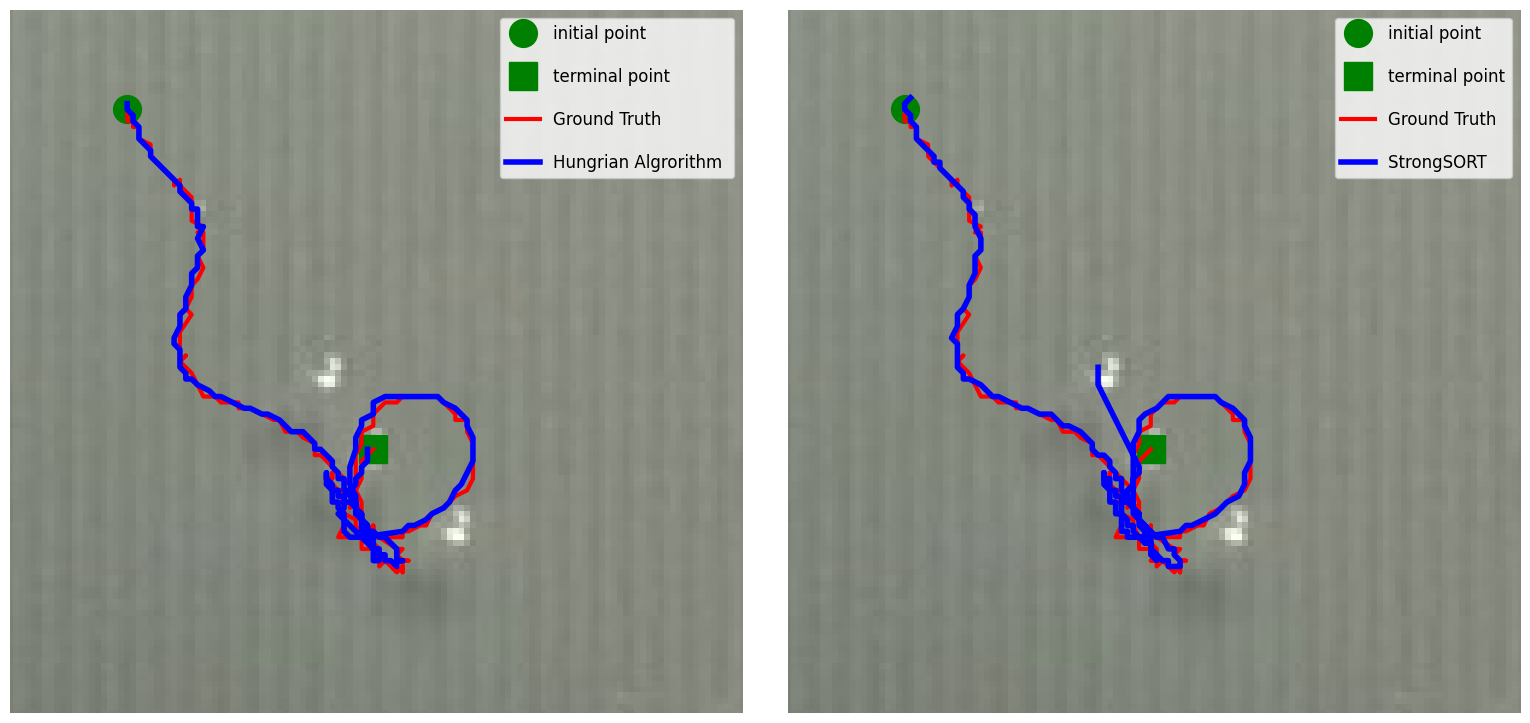

In [10]:
ms = 20
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
img = plt.imread(f'comparison/three_droplet/annot_three_drop/images/{str(int(frame_id_final[-1]))}.jpg')
ax[0].imshow(img)
ax[0].plot(xg1[0],yg1[0], 'go', label='initial point', markersize=ms)
ax[0].plot(xg1[-1],yg1[-1], 'gs', label='terminal point', markersize=ms)
ax[0].plot(xg1,yg1,'r-',label='Ground Truth',linewidth=3)
ax[0].plot(xh1,yh1,'b-',label='Hungrian Algrorithm ',linewidth=4)
ax[0].set_xlim([200,325])
ax[0].set_ylim([160,280])
ax[0].legend(labelspacing = 1.5,fontsize=12)
ax[0].invert_yaxis()
ax[0].axis('off')
ax[0].set_rasterized(True)

#deep-sort
ax[1].imshow(img)
ax[1].plot(xg1[0],yg1[0], 'go', label='initial point', markersize=ms)
ax[1].plot(xg1[-1],yg1[-1], 'gs', label='terminal point', markersize=ms)
ax[1].plot(xg1,yg1,'r-',label='Ground Truth',linewidth=3)
ax[1].plot(xd1,yd1,'b-',label='StrongSORT ',linewidth=4)
ax[1].set_xlim([200,325])
ax[1].set_ylim([160,280])
ax[1].legend(labelspacing = 1.5,fontsize=12)
ax[1].invert_yaxis()
ax[1].axis('off')
ax[1].set_rasterized(True)

fig.tight_layout()
fig.savefig(f'comparison/three_droplet/drop1.eps',format='eps', dpi=120)
plt.show()

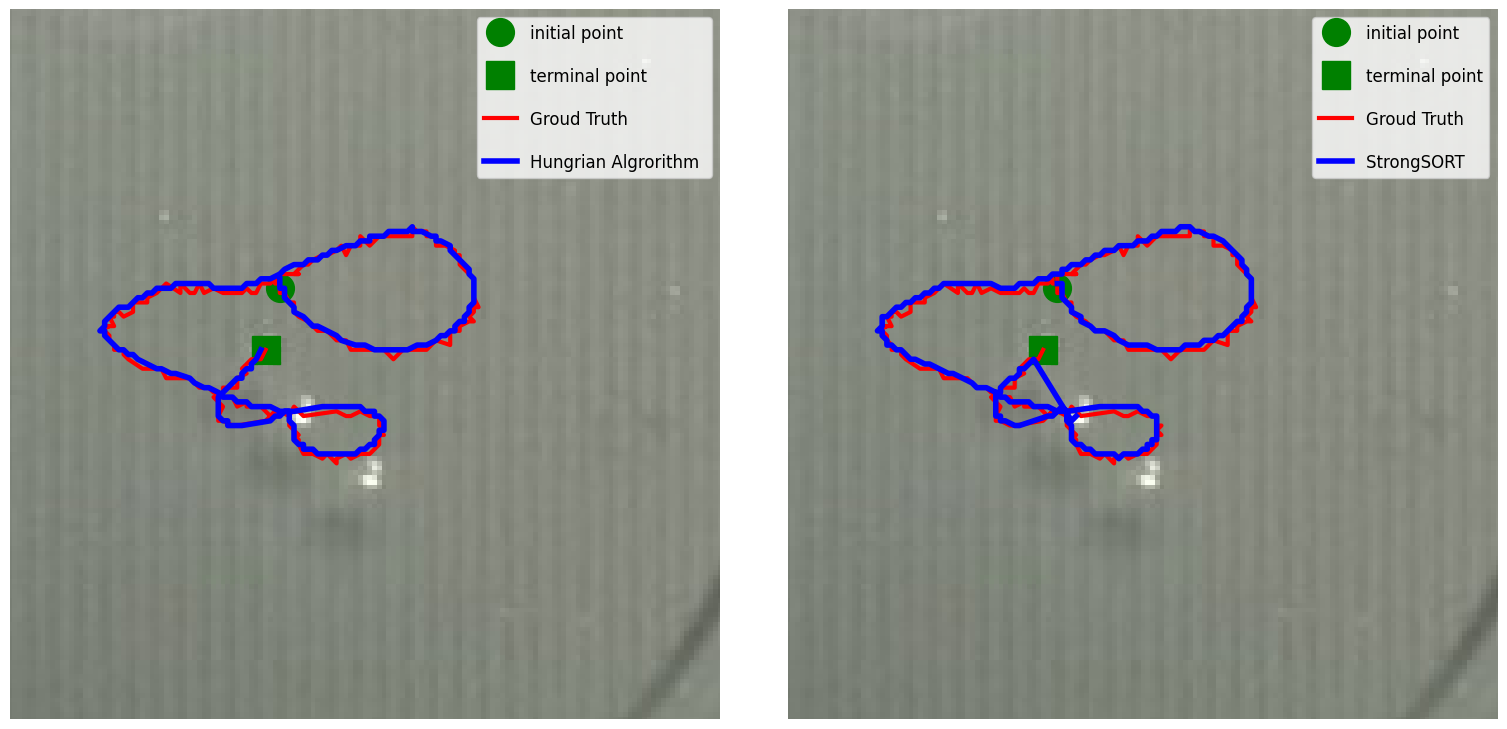

In [11]:
ms = 20
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
img = plt.imread(f'comparison/three_droplet/annot_three_drop/images/{str(int(frame_id_final[-1]))}.jpg')
ax[0].imshow(img)
ax[0].plot(xg2[0],yg2[0], 'go', label='initial point', markersize=ms)
ax[0].plot(xg2[-1],yg2[-1], 'gs', label='terminal point', markersize=ms)
ax[0].plot(xg2,yg2,'r-',label='Groud Truth',linewidth=3)
ax[0].plot(xh2,yh2,'b-',label='Hungrian Algrorithm ',linewidth=4)
ax[0].set_xlim([200,350])
ax[0].set_ylim([150,300])
ax[0].legend(labelspacing = 1.5,fontsize=12)
ax[0].invert_yaxis()
ax[0].axis('off')
ax[0].set_rasterized(True)

#deep-sort
ax[1].imshow(img)
ax[1].plot(xg2[0],yg2[0], 'go', label='initial point', markersize=ms)
ax[1].plot(xg2[-1],yg2[-1], 'gs', label='terminal point', markersize=ms)
ax[1].plot(xg2,yg2,'r-',label='Groud Truth',linewidth=3)
ax[1].plot(xd2,yd2,'b-',label='StrongSORT ',linewidth=4)
ax[1].set_xlim([200,350])
ax[1].set_ylim([150,300])
ax[1].legend(labelspacing = 1.5,fontsize=12)
ax[1].invert_yaxis()
ax[1].axis('off')
ax[1].set_rasterized(True)

fig.tight_layout()
fig.savefig(f'comparison/three_droplet/drop2.eps',format='eps', dpi=120)
plt.show()

In [ ]:
##this one matches
# fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
# img = plt.imread(f'comparison/three_droplet/annot_three_drop/images/{str(int(frame_id_final[-1]))}.jpg')
# ax[0].imshow(img)
# ax[0].plot(xg3[0],yg3[0], 'go', label='initial point', markersize=ms)
# ax[0].plot(xg3[-1],yg3[-1], 'gs', label='terminal point', markersize=ms)
# ax[0].plot(xg3,yg3,'r-',label='Groud Truth',linewidth=3)
# ax[0].plot(xh3,yh3,'b-',label='Hungrian Algrorithm ',linewidth=3)
# ax[0].set_xlim([150,350])
# ax[0].set_ylim([100,300])
# ax[0].legend(labelspacing = 1.5,fontsize=12)
# ax[0].invert_yaxis()
# ax[0].axis('off')
# ax[0].set_rasterized(True)
# #deep-sort
# ax[1].imshow(img)
# ax[1].plot(xg3[0],yg3[0], 'go', label='initial point', markersize=ms)
# ax[1].plot(xg3[-1],yg3[-1], 'gs', label='terminal point', markersize=ms)
# ax[1].plot(xg3,yg3,'r-',label='Groud Truth',linewidth=3)
# ax[1].plot(xd3,yd3,'b-',label='StrongSORT ',linewidth=3)
# ax[1].set_xlim([150,350])
# ax[1].set_ylim([100,300])
# ax[1].legend(labelspacing = 1.5,fontsize=12)
# ax[1].invert_yaxis()
# ax[1].axis('off')
# ax[1].set_rasterized(True)

# fig.tight_layout()
# fig.savefig(f'comparison/three_droplet/drop3.eps',format='eps', dpi=120)
# plt.show()

## Optimal Training Images

In [ ]:
# def PlotmAP(exp_name,save_dir='./figures/'):
df = pd.read_csv("train_results/optimal_image_control.csv")
num_train = df['num_train_image']
mAP_05 = df['mAP@0.5']
mAP_0595 = df['mAP@0.5..0.95']
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(num_train, mAP_05, label='mAP@0.5',marker='o')
ax.plot(num_train, mAP_0595, label='mAP@0.5:0.95',marker='o')
ax.set_xlabel('#training images')
ax.set_ylabel('score')
ax.set_yticks([round(0.1*i,2) for i in range(11) ])
ax.grid(True)
ax.legend()
plt.tight_layout()
ax.set_rasterized(True)
plt.savefig('figures/full_train_control.eps',bbox_inches = 'tight',format='eps', dpi=120)
plt.show()

In [ ]:
df = pd.read_csv("train_results/optimal_image_control_3droplet.csv")
num_train = df['num_train_image']
mAP_05 = df['mAP@0.5']
mAP_0595 = df['mAP@0.5..0.95']
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(num_train, mAP_05, label='mAP@0.5',marker='o')
ax.plot(num_train, mAP_0595, label='mAP@0.5:0.95',marker='o')
ax.set_xlabel('#training images')
ax.set_ylabel('score')
ax.set_yticks([round(0.1*i,2) for i in range(11) ])
ax.grid(True)
ax.legend()
plt.tight_layout()
ax.set_rasterized(True)
plt.savefig('figures/full_train_three.eps',bbox_inches = 'tight',format='eps', dpi=120)
plt.show()

In [ ]:
df = pd.read_csv("train_results/optimal_image_control.csv")
num_train = df['num_train_image']
mAP_05 = df['mAP@0.5']
mAP_0595 = df['mAP@0.5..0.95']
fig,ax = plt.subplots(1,2,figsize=(20,8),sharey=True)

ax[0].plot(num_train, mAP_05, label='mAP@0.5',marker='o')
ax[0].plot(num_train, mAP_0595, label='mAP@0.5:0.95',marker='o')
ax[0].set_xlabel('#training images')
ax[0].set_ylabel('score')
ax[0].set_yticks([round(0.1*i,2) for i in range(11) ])
ax[0].grid(True)
ax[0].legend()
ax[0].set_rasterized(True)

df = pd.read_csv("train_results/optimal_image_control_3droplet.csv")
num_train = df['num_train_image']
mAP_05 = df['mAP@0.5']
mAP_0595 = df['mAP@0.5..0.95']
ax[1].plot(num_train, mAP_05, label='mAP@0.5',marker='o')
ax[1].plot(num_train, mAP_0595, label='mAP@0.5:0.95',marker='o')
ax[1].set_xlabel('#training images')
#ax[1].set_ylabel('score')
#ax[1].set_yticks([round(0.1*i,2) for i in range(11) ])
ax[1].grid(True)
ax[1].legend()
ax[1].set_rasterized(True)



plt.tight_layout()
plt.savefig('figures/full_train.eps',format='eps', dpi=120)
plt.show()